In [1]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt

import tensorflow as tf
import zfit
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from utils.kin_utils_edit import *
from utils.BtoKllgamma_utils import *
import pickle
ztf = zfit.ztf
ztyping = zfit.util.ztyping
ztypes = zfit.settings.ztypes


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
#TASK='LOAD'
TASK='SAMPLE'
n_events=100000

In [3]:
zfit.run.check_numerics = False
zfit.settings.set_verbosity(10)

In [4]:
mmu_mass = 105
mB_mass=5280
mKst_mass=892
mgamma_mass = 0.1

mBbar_mass=mB_mass-mgamma_mass

#lower_q= 2*mmu_mass
#upper_q=(mBbar_mass-mKst_mass)

lower_q2= 4*mmu_mass*mmu_mass
upper_q2=(mBbar_mass-mKst_mass)*(mBbar_mass-mKst_mass)


upper_mBbar2 = mBbar_mass**2
lower_mBbar2 = (2*mmu_mass+mKst_mass)*(2*mmu_mass+mKst_mass)

In [5]:
class dGamma(zfit.pdf.ZPDF):
    
    _PARAMS = ['mB','mKst','ml','mgamma']
    _N_OBS = 3
    
    
    def _unnormalized_pdf(self, x):
        

        mB = self.params['mB']      
        mKst = self.params['mKst']
        ml = self.params['ml']
        mgamma = self.params['mgamma']
        
        q2, mBbar2, cos_theta_l  = x.unstack_x()
        
        
        """
        Kinematic functions
        
        """
        beta_l = dphi2_tf(ztf.sqrt(q2), ml, ml)
        
        phasespace_term=dphi2_tf(mB, ztf.sqrt(mBbar2), mgamma)*dphi2_tf(ztf.sqrt(mBbar2), mKst, ztf.sqrt(q2))*beta_l
        
        lambda_bar = lambda_function(ztf.sqrt(mBbar2),mKst_mass,ztf.sqrt(q2))
        beta_K = ztf.sqrt(lambda_bar)/(mBbar2-q2+mKst_mass**2)
        beta_q = -ztf.sqrt(lambda_bar)/(mBbar2+q2-mKst_mass**2)
        
        gamma_q = 1/(1-ztf.square(beta_q))
        E_gamma = (mB_mass**2-mBbar2-mgamma_mass**2)/(2*ztf.sqrt(mBbar2))
        
        """
        Angular integrals
        
        """
        
        
        I12=2*pi*((1+ztf.square(beta_l))/beta_l)*ztf.log((1+beta_l)/(1-beta_l))
        IBK=(2*pi/beta_K)*ztf.log((1+beta_K)/(1-beta_K))
        
        ZBplus =(gamma_q*(1+beta_q*beta_l*cos_theta_l)+ztf.sqrt(1-ztf.square(beta_l)))/(gamma_q*(1+beta_q*beta_l*cos_theta_l)-ztf.sqrt(1-ztf.square(beta_l)))
        ZBminus =(gamma_q*(1-beta_q*beta_l*cos_theta_l)+ztf.sqrt(1-ztf.square(beta_l)))/(gamma_q*(1-beta_q*beta_l*cos_theta_l)-ztf.sqrt(1-ztf.square(beta_l)))        
        
        IBplus = 2*pi*((1+ZBplus)/(ztf.sqrt(ZBplus)))*ztf.log((ztf.sqrt(ZBplus)+1)/(ztf.sqrt(ZBplus)-1))
        IBminus = 2*pi*((1+ZBminus)/(ztf.sqrt(ZBminus)))*ztf.log((ztf.sqrt(ZBminus)+1)/(ztf.sqrt(ZBminus)-1))
        
        ZKplus = (gamma_q*(1-beta_K*beta_q + beta_l*(beta_q-beta_K)*cos_theta_l)+ztf.sqrt((1-ztf.square(beta_l))*(1-ztf.square(beta_K))))/(gamma_q*(1-beta_K*beta_q + beta_l*(beta_q-beta_K)*cos_theta_l)-ztf.sqrt((1-ztf.square(beta_l))*(1-ztf.square(beta_K))))
        ZKminus = (gamma_q*(1-beta_K*beta_q - beta_l*(beta_q-beta_K)*cos_theta_l)+ztf.sqrt((1-ztf.square(beta_l))*(1-ztf.square(beta_K))))/(gamma_q*(1-beta_K*beta_q - beta_l*(beta_q-beta_K)*cos_theta_l)-ztf.sqrt((1-ztf.square(beta_l))*(1-ztf.square(beta_K))))
        
        IKplus = 2*pi*((1+ZKplus)/(ztf.sqrt(ZKplus)))*ztf.log((ztf.sqrt(ZKplus)+1)/(ztf.sqrt(ZKplus)-1))
        IKminus = 2*pi*((1+ZKminus)/(ztf.sqrt(ZKminus)))*ztf.log((ztf.sqrt(ZKminus)+1)/(ztf.sqrt(ZKminus)-1))
        
        pdf_charged = -(1/ztf.square(E_gamma))*(4*(4*pi) +IBK -IBplus +IBminus - IKplus + IKminus -2*I12 )*phasespace_term
        #pdf_neutral = -(1/ztf.square(E_gamma))*(2*(4*pi) - 2*I12 )*phasespace_term
        #pdf =(1/ztf.square(E_gamma))* (2*(4*pi) -2*I12 )*phasespace_term
        
        
        return pdf_charged


In [6]:
mB_par = zfit.Parameter('mB', mB_mass)
mKst_par = zfit.Parameter('mKst', mKst_mass)
mgamma_par = zfit.Parameter('mgamma', mgamma_mass)
mlepton_par = zfit.Parameter('ml', mmu_mass)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
lower = ((lower_q2, lower_mBbar2, -1. ,),)
upper = ((upper_q2, upper_mBbar2,  1. ,),)

obs = zfit.Space(["q2","mBbar2","cos_theta_l",], limits=(lower,upper))

pdf = dGamma(obs=obs, ml = mlepton_par, mB = mB_par, mKst = mKst_par, mgamma= mgamma_par)

sampler = pdf.create_sampler(n=n_events)



Instructions for updating:
Use tf.cast instead.


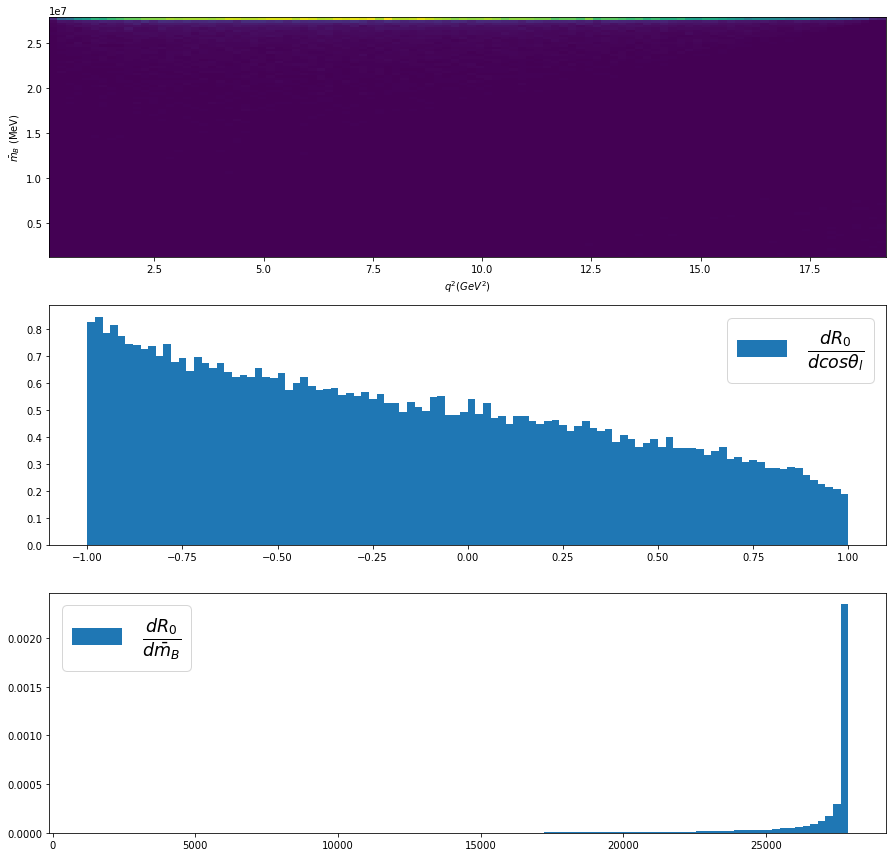

In [8]:
if TASK=='SAMPLE':
    
    for i in range(1):
        sampler.resample()
    sample = sampler.to_pandas()
    
    
    q2vals = np.array([sample['q2'][i] for i in range(n_events)]).reshape(n_events,1)
    mBbar2vals = np.array([sample['mBbar2'][i] for i in range(n_events)]).reshape(n_events,1)
    cos_theta_vals = np.array([sample['cos_theta_l'][i] for i in range(n_events)]).reshape(n_events,1)
    
    plt.hist(q2vals[:,0],density=True,bins=100);
    fig = plt.gcf()
    fig.set_size_inches(15,5);
    
    plt.subplot(3,1,1)
    #plt.hist2d(q2vals,mBbarvals,density=True,bins=100);
    plt.hist2d(q2vals[:,0]/1e6,mBbar2vals[:,0],label=r'$\frac{dR_{0}}{dcos_{\theta l}}$',density=True,bins=100);
    plt.xlabel(r'$q^{2} (GeV^{2})$');
    plt.ylabel(r'$\bar{m}_{B}$ (MeV)');
    plt.subplot(3,1,2)
    plt.hist(cos_theta_vals,label=r'$\frac{dR_{0}}{dcos{\theta_l}}$',density=True,bins=100);
    plt.legend(fontsize='25');
    fig = plt.gcf()
    fig.set_size_inches(15,5)
    plt.subplot(3,1,3)
    plt.hist(mBbar2vals/1e3,label=r'$\frac{dR_{0}}{d\bar{m}_{B}}$',density=True,bins=100);
    plt.legend(fontsize='25');
    fig = plt.gcf()
    fig.set_size_inches(15,15);
       
    pKst_Bbar, q_Bbar, p1_Bbar, p2_Bbar, p1, p2 = momenta_map(q2vals, cos_theta_vals, mB_mass, mBbar2vals, mKst_mass, mmu_mass, mgamma_mass, mode='numpy')


In [9]:
if TASK=='LOAD':
    
    #with open('/home/hep/davide/MC_qedbtokst/new_MC_tuple_B+toK+mumu_100K_10eVCutOff.pickle','rb') as f:
    #    MC_tuple= pickle.load(f)
    with open('/home/hep/davide/MC_qedbtokst/new_MC_tuple_B0toK0mumu_500K_100eVCutOff.pickle','rb') as f:
        MC_tuple= pickle.load(f)
        
    pB_Bbar = MC_tuple['pB_Bbar']
    pKst_Bbar = MC_tuple['pKst_Bbar']    
    k_Bbar = MC_tuple['k_Bbar']
    q_Bbar = MC_tuple['q_Bbar']
    p1_Bbar = MC_tuple['p1_Bbar']
    p2_Bbar = MC_tuple['p2_Bbar']
    p1 = MC_tuple['p1']
    p2 = MC_tuple['p2']
    
    pBbar = p1_Bbar+p2_Bbar+pKst_Bbar
    
    q2vals = scalar_product_4_np((p1+p2),(p1+p2))
    mBbarvals = np.sqrt(scalar_product_4_np(pBbar,pBbar))
    
    
    plt.subplot(3,1,1)
    plt.hist(q2vals/1e6,density=True, label=r'$\frac{dR_{0}}{dq^{2}}$', bins=100);
    plt.legend(fontsize='30');
    plt.subplot(3,1,2)    
    plt.hist(mBbarvals,density=True,label=r'$\frac{dR_{0}}{d\bar{m}_{B}}$',bins=100);
    plt.legend(fontsize='30');
    plt.subplot(3,1,3)        
    plt.hist2d(q2vals/1e6,mBbarvals,label=r'$\frac{dR_{0}}{dcos_{\theta l}}$', range=((q2vals.min()/1e6,q2vals.max()/1e6),(5270,mBbarvals.max())),density=True,bins=100);
    plt.xlabel(r'$q^{2} (GeV^{2})$');
    plt.ylabel(r'$\bar{m}_{B}$ (MeV)');
    
    fig = plt.gcf()
    fig.set_size_inches(15,12);

In [10]:
(np.sqrt(scalar_product_4_np(p2_Bbar,p2_Bbar))).mean()

105.00000000000001

In [11]:
Kst_mass_check = (np.sqrt(scalar_product_4_np(pKst_Bbar,pKst_Bbar))).mean()-mKst_mass<10**-10
lepton_mass_check = (np.sqrt(scalar_product_4_np(p2_Bbar,p2_Bbar))).mean()-mmu_mass<10**-10
#B_mass_check = (np.sqrt(scalar_product_4_np(pB_Bbar,pB_Bbar))).mean()-mB_mass<10**10                   
#photon_mass_check = (scalar_product_4_np(k_Bbar,k_Bbar)).mean()-mgamma_mass<10**-10

if Kst_mass_check and lepton_mass_check:
    print('Mass checks ok')
else:
    print('Mass checks not good')
    print('Kst mass', Kst_mass_check)
    print('lepton mass', lepton_mass_check)
    print('B mass', B_mass_check)
    print('photon_mass_check', photon_mass_check)
    
#pB_Bbar_to_boost=pB_Bbar
#pB = lorentz_boost_np(pB_Bbar_to_boost, -pB_Bbar[:,0:3]/pB_Bbar[:,3:4])

#spatial_rest_check=pB[:,0].mean()<10**-10 and pB[:,1].mean()<10**-10 and pB[:,2].mean()<10**-10
#Brest_mass_check=pB[:,3].mean()==mB_mass
#
#if spatial_rest_check and Brest_mass_check:
#    print('B rest frame ok')
#else:
#    print('B rest frame not good')

Mass checks ok


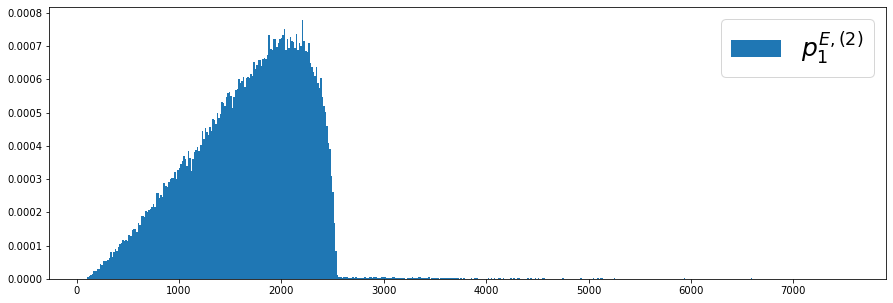

In [12]:
plt.hist(p1_Bbar[:,0], label=r'$p_{1}^{E, (2)}$', density=True,bins=500);
plt.legend(fontsize='25');
fig = plt.gcf()
fig.set_size_inches(15,5)

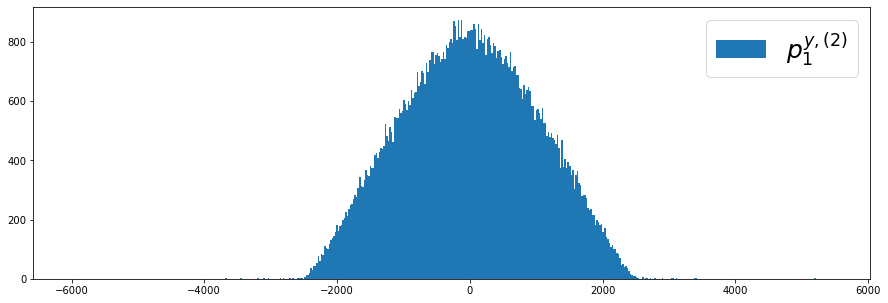

In [13]:
plt.hist(p1_Bbar[:,2], label=r'$p_{1}^{y, (2)}$',bins=500);
plt.legend(fontsize='25');
fig = plt.gcf()
fig.set_size_inches(15,5)

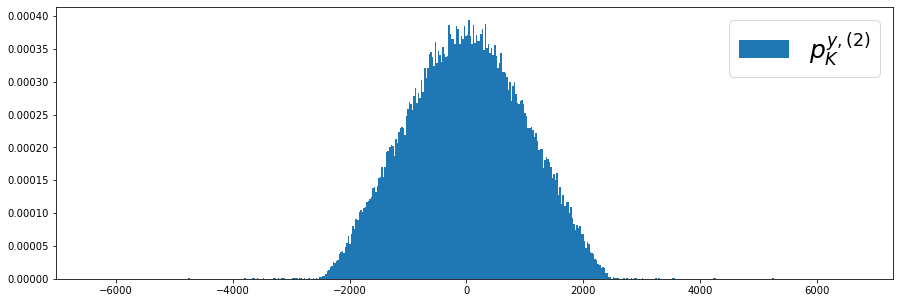

In [14]:
plt.hist(pKst_Bbar[:,2],density=True, label=r'$p_{K}^{y, (2)}$',bins=500);
plt.legend(fontsize='25');
fig = plt.gcf()
fig.set_size_inches(15,5)

In [15]:
p1_Bbar_to_boost=p1_Bbar
p2_Bbar_to_boost=p2_Bbar

In [16]:
p1_q = lorentz_boost_np(p1_Bbar_to_boost, -q_Bbar/q_Bbar[:,0:1])
p2_q = lorentz_boost_np(p2_Bbar_to_boost, -q_Bbar/q_Bbar[:,0:1])

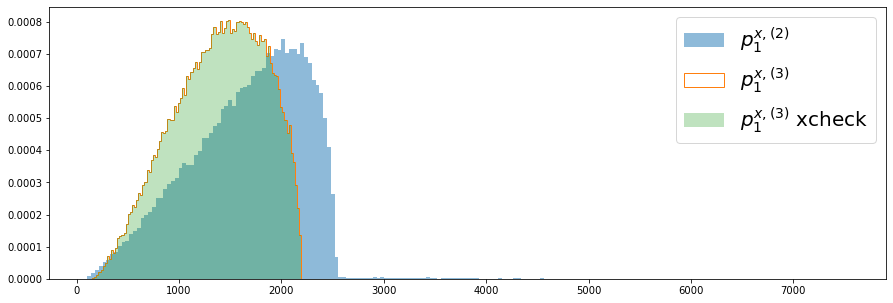

In [17]:
plt.hist(p1_Bbar[:,0],alpha=0.5, density=True,label=r'$p_{1}^{x, (2)}$', bins=200);
plt.hist(p1[:,0],histtype="step", density=True,label=r'$p_{1}^{x, (3)}$',bins=100);
plt.hist(p1_q[:,0],alpha=0.3,label=r'$p_{1}^{x, (3)}$ xcheck', density=True,bins=100);
plt.legend(fontsize='20');
fig = plt.gcf()
fig.set_size_inches(15,5)

In [18]:
z=np.array([[0.,0.,0.,1.] for i in range(p1_Bbar.shape[0])])

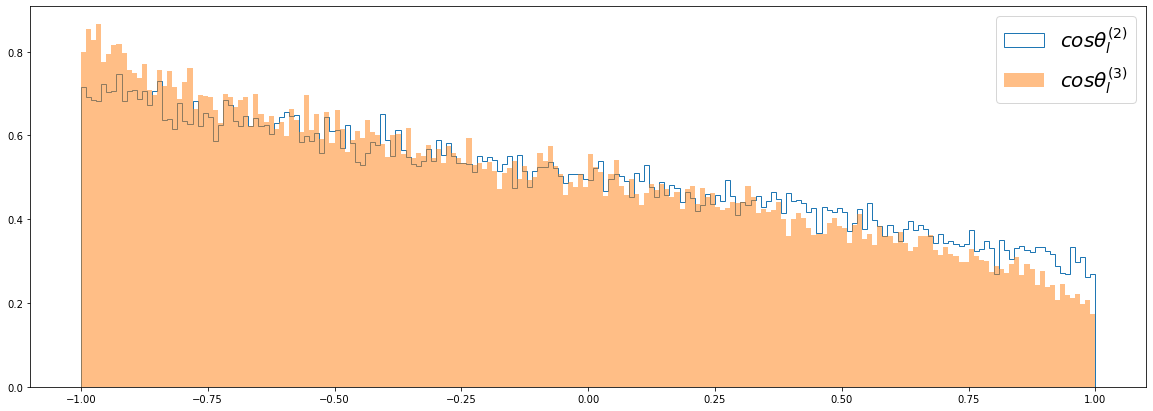

In [19]:
cos_theta_l_np_Bbar=get_costheta_l_np(p1_Bbar,z)
cos_theta_l_np_q=get_costheta_l_np(p1_q,z)
plt.hist(cos_theta_l_np_Bbar,bins=200, histtype="step", label=r'$cos\theta_{l}^{(2)}$', density=True);
plt.hist(cos_theta_l_np_q,bins=200, alpha=0.5,label=r'$cos\theta_{l}^{(3)}$',density=True);
plt.legend(fontsize='20');
fig = plt.gcf()
fig.set_size_inches(20,7)


In [20]:
if TASK=='SAMPLE':
    
    MC_tuple = {}
    
    #MC_tuple['pB_Bbar']=pB_Bbar
    MC_tuple['pKst_Bbar']=pKst_Bbar
    #MC_tuple['k_Bbar']=k_Bbar
    MC_tuple['q_Bbar']=q_Bbar
    MC_tuple['p1_Bbar']=p1_Bbar
    MC_tuple['p2_Bbar']=p2_Bbar
    MC_tuple['p1']=p1
    MC_tuple['p2']=p2
    MC_tuple['cos_theta_l(2)']=cos_theta_l_np_Bbar
    MC_tuple['cos_theta_l(3)']=cos_theta_l_np_q
    MC_tuple['q2']=q2vals

    with open('new_MC_tuple_B-toK-mumu_50K_100eVCutOff_trial.pickle','wb') as handle:
        pickle.dump(MC_tuple, handle)